# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 20, 20, 20, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 20, 20, 20, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8888
Epoch 1/200, Iteration 2/12, Loss: 0.8303
Epoch 1/200, Iteration 3/12, Loss: 0.7361
Epoch 1/200, Iteration 4/12, Loss: 0.6962
Epoch 1/200, Iteration 5/12, Loss: 0.5834
Epoch 1/200, Iteration 6/12, Loss: 0.4936
Epoch 1/200, Iteration 7/12, Loss: 0.3841
Epoch 1/200, Iteration 8/12, Loss: 0.4293
Epoch 1/200, Iteration 9/12, Loss: 0.3223
Epoch 1/200, Iteration 10/12, Loss: 0.3314
Epoch 1/200, Iteration 11/12, Loss: 0.2808
Epoch 1/200, Iteration 12/12, Loss: 0.2803
Epoch 1/200, Iteration 13/12, Loss: 0.3044
Train Error: 
 Accuracy: 42.25%, Avg loss: 0.300667, MRE: 0.252773, MAE: 0.037121 

Test Error: 
 Accuracy: 49.0%, Avg loss: 0.288066, MRE: 0.213845, MAE: 0.036497 

Epoch 2/200, Iteration 1/12, Loss: 0.2923
Epoch 2/200, Iteration 2/12, Loss: 0.3147
Epoch 2/200, Iteration 3/12, Loss: 0.3377
Epoch 2/200, Iteration 4/12, Loss: 0.3026
Epoch 2/200, Iteration 5/12, Loss: 0.2770
Epoch 2/200, Iteration 6/12, Loss: 0.2688
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.055023, MRE: 0.040601, MAE: 0.007160 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.052088, MRE: 0.032715, MAE: 0.006894 

Epoch 13/200, Iteration 1/12, Loss: 0.0501
Epoch 13/200, Iteration 2/12, Loss: 0.0668
Epoch 13/200, Iteration 3/12, Loss: 0.0725
Epoch 13/200, Iteration 4/12, Loss: 0.0527
Epoch 13/200, Iteration 5/12, Loss: 0.0735
Epoch 13/200, Iteration 6/12, Loss: 0.0504
Epoch 13/200, Iteration 7/12, Loss: 0.0540
Epoch 13/200, Iteration 8/12, Loss: 0.0444
Epoch 13/200, Iteration 9/12, Loss: 0.0506
Epoch 13/200, Iteration 10/12, Loss: 0.0557
Epoch 13/200, Iteration 11/12, Loss: 0.0568
Epoch 13/200, Iteration 12/12, Loss: 0.0531
Epoch 13/200, Iteration 13/12, Loss: 0.0507
Train Error: 
 Accuracy: 90.12%, Avg loss: 0.053352, MRE: 0.046825, MAE: 0.006730 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.050452, MRE: 0.038724, MAE: 0.006320 

Epoch 14/200, Iteration 1/12, Loss: 0.0485
Epoch 14/200, Iteration 2/12, Loss: 0.0566
Epoch 14/200, Itera

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.044134, MRE: 0.036116, MAE: 0.004920 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.042496, MRE: 0.030823, MAE: 0.004787 

Epoch 25/200, Iteration 1/12, Loss: 0.0456
Epoch 25/200, Iteration 2/12, Loss: 0.0468
Epoch 25/200, Iteration 3/12, Loss: 0.0416
Epoch 25/200, Iteration 4/12, Loss: 0.0573
Epoch 25/200, Iteration 5/12, Loss: 0.0504
Epoch 25/200, Iteration 6/12, Loss: 0.0422
Epoch 25/200, Iteration 7/12, Loss: 0.0417
Epoch 25/200, Iteration 8/12, Loss: 0.0454
Epoch 25/200, Iteration 9/12, Loss: 0.0470
Epoch 25/200, Iteration 10/12, Loss: 0.0257
Epoch 25/200, Iteration 11/12, Loss: 0.0531
Epoch 25/200, Iteration 12/12, Loss: 0.0385
Epoch 25/200, Iteration 13/12, Loss: 0.0426
Train Error: 
 Accuracy: 91.75%, Avg loss: 0.048882, MRE: 0.036125, MAE: 0.005828 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.047415, MRE: 0.032404, MAE: 0.005750 

Epoch 26/200, Iteration 1/12, Loss: 0.0601
Epoch 26/200, Iteration 2/12, Loss: 0.0453
Epoch 26/200, Iterat

Epoch 36/200, Iteration 10/12, Loss: 0.0218
Epoch 36/200, Iteration 11/12, Loss: 0.0270
Epoch 36/200, Iteration 12/12, Loss: 0.0235
Epoch 36/200, Iteration 13/12, Loss: 0.0246
Train Error: 
 Accuracy: 98.25%, Avg loss: 0.021512, MRE: 0.020819, MAE: 0.002816 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.021633, MRE: 0.016267, MAE: 0.002863 

Epoch 37/200, Iteration 1/12, Loss: 0.0201
Epoch 37/200, Iteration 2/12, Loss: 0.0234
Epoch 37/200, Iteration 3/12, Loss: 0.0185
Epoch 37/200, Iteration 4/12, Loss: 0.0198
Epoch 37/200, Iteration 5/12, Loss: 0.0228
Epoch 37/200, Iteration 6/12, Loss: 0.0168
Epoch 37/200, Iteration 7/12, Loss: 0.0226
Epoch 37/200, Iteration 8/12, Loss: 0.0160
Epoch 37/200, Iteration 9/12, Loss: 0.0157
Epoch 37/200, Iteration 10/12, Loss: 0.0263
Epoch 37/200, Iteration 11/12, Loss: 0.0323
Epoch 37/200, Iteration 12/12, Loss: 0.0174
Epoch 37/200, Iteration 13/12, Loss: 0.0163
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.020985, MRE: 0.018459, MAE: 0.002694 

Test Error: 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017797, MRE: 0.014488, MAE: 0.002289 

Epoch 48/200, Iteration 1/12, Loss: 0.0173
Epoch 48/200, Iteration 2/12, Loss: 0.0203
Epoch 48/200, Iteration 3/12, Loss: 0.0223
Epoch 48/200, Iteration 4/12, Loss: 0.0214
Epoch 48/200, Iteration 5/12, Loss: 0.0166
Epoch 48/200, Iteration 6/12, Loss: 0.0122
Epoch 48/200, Iteration 7/12, Loss: 0.0157
Epoch 48/200, Iteration 8/12, Loss: 0.0219
Epoch 48/200, Iteration 9/12, Loss: 0.0187
Epoch 48/200, Iteration 10/12, Loss: 0.0223
Epoch 48/200, Iteration 11/12, Loss: 0.0164
Epoch 48/200, Iteration 12/12, Loss: 0.0188
Epoch 48/200, Iteration 13/12, Loss: 0.0121
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.018250, MRE: 0.017895, MAE: 0.002301 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018691, MRE: 0.015541, MAE: 0.002382 

Epoch 49/200, Iteration 1/12, Loss: 0.0194
Epoch 49/200, Iteration 2/12, Loss: 0.0213
Epoch 49/200, Iteration 3/12, Loss: 0.0131
Epoch 49/200, Iteration 4/12, Loss: 0.0195
Epoch 49/200, Ite

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016168, MRE: 0.013558, MAE: 0.002058 

Epoch 60/200, Iteration 1/12, Loss: 0.0118
Epoch 60/200, Iteration 2/12, Loss: 0.0204
Epoch 60/200, Iteration 3/12, Loss: 0.0164
Epoch 60/200, Iteration 4/12, Loss: 0.0137
Epoch 60/200, Iteration 5/12, Loss: 0.0195
Epoch 60/200, Iteration 6/12, Loss: 0.0185
Epoch 60/200, Iteration 7/12, Loss: 0.0162
Epoch 60/200, Iteration 8/12, Loss: 0.0259
Epoch 60/200, Iteration 9/12, Loss: 0.0130
Epoch 60/200, Iteration 10/12, Loss: 0.0144
Epoch 60/200, Iteration 11/12, Loss: 0.0147
Epoch 60/200, Iteration 12/12, Loss: 0.0148
Epoch 60/200, Iteration 13/12, Loss: 0.0282
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.017001, MRE: 0.016216, MAE: 0.002104 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.016648, MRE: 0.013830, MAE: 0.002097 

Epoch 61/200, Iteration 1/12, Loss: 0.0188
Epoch 61/200, Iteration 2/12, Loss: 0.0189
Epoch 61/200, Iteration 3/12, Loss: 0.0152
Epoch 61/200, Iteration 4/12, Loss: 0.0158
Epoch 61/200, Iter

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.016732, MRE: 0.015569, MAE: 0.002106 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015768, MRE: 0.013110, MAE: 0.001999 

Epoch 73/200, Iteration 1/12, Loss: 0.0134
Epoch 73/200, Iteration 2/12, Loss: 0.0145
Epoch 73/200, Iteration 3/12, Loss: 0.0162
Epoch 73/200, Iteration 4/12, Loss: 0.0189
Epoch 73/200, Iteration 5/12, Loss: 0.0200
Epoch 73/200, Iteration 6/12, Loss: 0.0182
Epoch 73/200, Iteration 7/12, Loss: 0.0100
Epoch 73/200, Iteration 8/12, Loss: 0.0237
Epoch 73/200, Iteration 9/12, Loss: 0.0192
Epoch 73/200, Iteration 10/12, Loss: 0.0151
Epoch 73/200, Iteration 11/12, Loss: 0.0126
Epoch 73/200, Iteration 12/12, Loss: 0.0129
Epoch 73/200, Iteration 13/12, Loss: 0.0181
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.015401, MRE: 0.014968, MAE: 0.001959 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.015366, MRE: 0.012621, MAE: 0.001992 

Epoch 74/200, Iteration 1/12, Loss: 0.0144
Epoch 74/200, Iteration 2/12, Loss: 0.0219
Epoch 74/200, Iterat

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.014679, MRE: 0.014797, MAE: 0.001817 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.014177, MRE: 0.012143, MAE: 0.001797 

Epoch 85/200, Iteration 1/12, Loss: 0.0157
Epoch 85/200, Iteration 2/12, Loss: 0.0150
Epoch 85/200, Iteration 3/12, Loss: 0.0158
Epoch 85/200, Iteration 4/12, Loss: 0.0141
Epoch 85/200, Iteration 5/12, Loss: 0.0126
Epoch 85/200, Iteration 6/12, Loss: 0.0106
Epoch 85/200, Iteration 7/12, Loss: 0.0156
Epoch 85/200, Iteration 8/12, Loss: 0.0200
Epoch 85/200, Iteration 9/12, Loss: 0.0158
Epoch 85/200, Iteration 10/12, Loss: 0.0127
Epoch 85/200, Iteration 11/12, Loss: 0.0107
Epoch 85/200, Iteration 12/12, Loss: 0.0216
Epoch 85/200, Iteration 13/12, Loss: 0.0146
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.015367, MRE: 0.015642, MAE: 0.001898 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.014692, MRE: 0.011968, MAE: 0.001833 

Epoch 86/200, Iteration 1/12, Loss: 0.0120
Epoch 86/200, Iteration 2/12, Loss: 0.0132
Epoch 86/200, Iter

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.013608, MRE: 0.013864, MAE: 0.001709 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012940, MRE: 0.010961, MAE: 0.001643 

Epoch 98/200, Iteration 1/12, Loss: 0.0099
Epoch 98/200, Iteration 2/12, Loss: 0.0154
Epoch 98/200, Iteration 3/12, Loss: 0.0216
Epoch 98/200, Iteration 4/12, Loss: 0.0131
Epoch 98/200, Iteration 5/12, Loss: 0.0126
Epoch 98/200, Iteration 6/12, Loss: 0.0196
Epoch 98/200, Iteration 7/12, Loss: 0.0203
Epoch 98/200, Iteration 8/12, Loss: 0.0125
Epoch 98/200, Iteration 9/12, Loss: 0.0121
Epoch 98/200, Iteration 10/12, Loss: 0.0123
Epoch 98/200, Iteration 11/12, Loss: 0.0145
Epoch 98/200, Iteration 12/12, Loss: 0.0132
Epoch 98/200, Iteration 13/12, Loss: 0.0133
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.015844, MRE: 0.017325, MAE: 0.001889 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.014994, MRE: 0.013591, MAE: 0.001836 

Epoch 99/200, Iteration 1/12, Loss: 0.0129
Epoch 99/200, Iteration 2/12, Loss: 0.0120
Epoch 99/200, Iter

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.013235, MRE: 0.013923, MAE: 0.001680 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012853, MRE: 0.010933, MAE: 0.001650 

Epoch 110/200, Iteration 1/12, Loss: 0.0136
Epoch 110/200, Iteration 2/12, Loss: 0.0129
Epoch 110/200, Iteration 3/12, Loss: 0.0128
Epoch 110/200, Iteration 4/12, Loss: 0.0144
Epoch 110/200, Iteration 5/12, Loss: 0.0127
Epoch 110/200, Iteration 6/12, Loss: 0.0154
Epoch 110/200, Iteration 7/12, Loss: 0.0107
Epoch 110/200, Iteration 8/12, Loss: 0.0119
Epoch 110/200, Iteration 9/12, Loss: 0.0174
Epoch 110/200, Iteration 10/12, Loss: 0.0192
Epoch 110/200, Iteration 11/12, Loss: 0.0122
Epoch 110/200, Iteration 12/12, Loss: 0.0136
Epoch 110/200, Iteration 13/12, Loss: 0.0117
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.013455, MRE: 0.013596, MAE: 0.001679 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012943, MRE: 0.011187, MAE: 0.001625 

Epoch 111/200, Iteration 1/12, Loss: 0.0157
Epoch 111/200, Iteration 2/12, Loss: 0.0104
Ep

Epoch 121/200, Iteration 4/12, Loss: 0.0131
Epoch 121/200, Iteration 5/12, Loss: 0.0110
Epoch 121/200, Iteration 6/12, Loss: 0.0128
Epoch 121/200, Iteration 7/12, Loss: 0.0144
Epoch 121/200, Iteration 8/12, Loss: 0.0134
Epoch 121/200, Iteration 9/12, Loss: 0.0128
Epoch 121/200, Iteration 10/12, Loss: 0.0107
Epoch 121/200, Iteration 11/12, Loss: 0.0106
Epoch 121/200, Iteration 12/12, Loss: 0.0111
Epoch 121/200, Iteration 13/12, Loss: 0.0127
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.012366, MRE: 0.012757, MAE: 0.001559 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.011724, MRE: 0.010205, MAE: 0.001499 

Epoch 122/200, Iteration 1/12, Loss: 0.0172
Epoch 122/200, Iteration 2/12, Loss: 0.0100
Epoch 122/200, Iteration 3/12, Loss: 0.0112
Epoch 122/200, Iteration 4/12, Loss: 0.0139
Epoch 122/200, Iteration 5/12, Loss: 0.0112
Epoch 122/200, Iteration 6/12, Loss: 0.0170
Epoch 122/200, Iteration 7/12, Loss: 0.0085
Epoch 122/200, Iteration 8/12, Loss: 0.0107
Epoch 122/200, Iteration 9/12, Loss: 

Epoch 132/200, Iteration 7/12, Loss: 0.0123
Epoch 132/200, Iteration 8/12, Loss: 0.0143
Epoch 132/200, Iteration 9/12, Loss: 0.0107
Epoch 132/200, Iteration 10/12, Loss: 0.0151
Epoch 132/200, Iteration 11/12, Loss: 0.0154
Epoch 132/200, Iteration 12/12, Loss: 0.0125
Epoch 132/200, Iteration 13/12, Loss: 0.0104
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.011423, MRE: 0.012255, MAE: 0.001424 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010737, MRE: 0.009642, MAE: 0.001352 

Epoch 133/200, Iteration 1/12, Loss: 0.0135
Epoch 133/200, Iteration 2/12, Loss: 0.0087
Epoch 133/200, Iteration 3/12, Loss: 0.0118
Epoch 133/200, Iteration 4/12, Loss: 0.0113
Epoch 133/200, Iteration 5/12, Loss: 0.0094
Epoch 133/200, Iteration 6/12, Loss: 0.0109
Epoch 133/200, Iteration 7/12, Loss: 0.0086
Epoch 133/200, Iteration 8/12, Loss: 0.0111
Epoch 133/200, Iteration 9/12, Loss: 0.0145
Epoch 133/200, Iteration 10/12, Loss: 0.0167
Epoch 133/200, Iteration 11/12, Loss: 0.0158
Epoch 133/200, Iteration 12/12, Los

Train Error: 
 Accuracy: 98.88%, Avg loss: 0.010996, MRE: 0.012227, MAE: 0.001369 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010612, MRE: 0.009617, MAE: 0.001336 

Epoch 144/200, Iteration 1/12, Loss: 0.0100
Epoch 144/200, Iteration 2/12, Loss: 0.0113
Epoch 144/200, Iteration 3/12, Loss: 0.0169
Epoch 144/200, Iteration 4/12, Loss: 0.0102
Epoch 144/200, Iteration 5/12, Loss: 0.0084
Epoch 144/200, Iteration 6/12, Loss: 0.0073
Epoch 144/200, Iteration 7/12, Loss: 0.0125
Epoch 144/200, Iteration 8/12, Loss: 0.0102
Epoch 144/200, Iteration 9/12, Loss: 0.0135
Epoch 144/200, Iteration 10/12, Loss: 0.0112
Epoch 144/200, Iteration 11/12, Loss: 0.0116
Epoch 144/200, Iteration 12/12, Loss: 0.0126
Epoch 144/200, Iteration 13/12, Loss: 0.0086
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.010952, MRE: 0.012076, MAE: 0.001368 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010615, MRE: 0.009643, MAE: 0.001345 

Epoch 145/200, Iteration 1/12, Loss: 0.0166
Epoch 145/200, Iteration 2/12, Loss: 0.0100
Ep

Epoch 156/200, Iteration 7/12, Loss: 0.0108
Epoch 156/200, Iteration 8/12, Loss: 0.0102
Epoch 156/200, Iteration 9/12, Loss: 0.0142
Epoch 156/200, Iteration 10/12, Loss: 0.0103
Epoch 156/200, Iteration 11/12, Loss: 0.0120
Epoch 156/200, Iteration 12/12, Loss: 0.0111
Epoch 156/200, Iteration 13/12, Loss: 0.0089
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.010894, MRE: 0.012029, MAE: 0.001358 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010427, MRE: 0.009561, MAE: 0.001318 

Epoch 157/200, Iteration 1/12, Loss: 0.0096
Epoch 157/200, Iteration 2/12, Loss: 0.0144
Epoch 157/200, Iteration 3/12, Loss: 0.0114
Epoch 157/200, Iteration 4/12, Loss: 0.0109
Epoch 157/200, Iteration 5/12, Loss: 0.0109
Epoch 157/200, Iteration 6/12, Loss: 0.0075
Epoch 157/200, Iteration 7/12, Loss: 0.0081
Epoch 157/200, Iteration 8/12, Loss: 0.0133
Epoch 157/200, Iteration 9/12, Loss: 0.0132
Epoch 157/200, Iteration 10/12, Loss: 0.0133
Epoch 157/200, Iteration 11/12, Loss: 0.0106
Epoch 157/200, Iteration 12/12, Los

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010440, MRE: 0.009559, MAE: 0.001319 

Epoch 168/200, Iteration 1/12, Loss: 0.0123
Epoch 168/200, Iteration 2/12, Loss: 0.0106
Epoch 168/200, Iteration 3/12, Loss: 0.0123
Epoch 168/200, Iteration 4/12, Loss: 0.0068
Epoch 168/200, Iteration 5/12, Loss: 0.0121
Epoch 168/200, Iteration 6/12, Loss: 0.0121
Epoch 168/200, Iteration 7/12, Loss: 0.0073
Epoch 168/200, Iteration 8/12, Loss: 0.0148
Epoch 168/200, Iteration 9/12, Loss: 0.0098
Epoch 168/200, Iteration 10/12, Loss: 0.0111
Epoch 168/200, Iteration 11/12, Loss: 0.0115
Epoch 168/200, Iteration 12/12, Loss: 0.0104
Epoch 168/200, Iteration 13/12, Loss: 0.0127
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.010978, MRE: 0.012273, MAE: 0.001371 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010426, MRE: 0.009565, MAE: 0.001318 

Epoch 169/200, Iteration 1/12, Loss: 0.0086
Epoch 169/200, Iteration 2/12, Loss: 0.0102
Epoch 169/200, Iteration 3/12, Loss: 0.0112
Epoch 169/200, Iteration 4/12, Loss: 0.009

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010424, MRE: 0.009538, MAE: 0.001318 

Epoch 180/200, Iteration 1/12, Loss: 0.0084
Epoch 180/200, Iteration 2/12, Loss: 0.0119
Epoch 180/200, Iteration 3/12, Loss: 0.0090
Epoch 180/200, Iteration 4/12, Loss: 0.0144
Epoch 180/200, Iteration 5/12, Loss: 0.0136
Epoch 180/200, Iteration 6/12, Loss: 0.0076
Epoch 180/200, Iteration 7/12, Loss: 0.0140
Epoch 180/200, Iteration 8/12, Loss: 0.0132
Epoch 180/200, Iteration 9/12, Loss: 0.0097
Epoch 180/200, Iteration 10/12, Loss: 0.0099
Epoch 180/200, Iteration 11/12, Loss: 0.0089
Epoch 180/200, Iteration 12/12, Loss: 0.0096
Epoch 180/200, Iteration 13/12, Loss: 0.0138
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.010865, MRE: 0.012122, MAE: 0.001354 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010422, MRE: 0.009539, MAE: 0.001318 

Epoch 181/200, Iteration 1/12, Loss: 0.0099
Epoch 181/200, Iteration 2/12, Loss: 0.0073
Epoch 181/200, Iteration 3/12, Loss: 0.0163
Epoch 181/200, Iteration 4/12, Loss: 0.010

Epoch 191/200, Iteration 1/12, Loss: 0.0113
Epoch 191/200, Iteration 2/12, Loss: 0.0075
Epoch 191/200, Iteration 3/12, Loss: 0.0135
Epoch 191/200, Iteration 4/12, Loss: 0.0079
Epoch 191/200, Iteration 5/12, Loss: 0.0080
Epoch 191/200, Iteration 6/12, Loss: 0.0086
Epoch 191/200, Iteration 7/12, Loss: 0.0110
Epoch 191/200, Iteration 8/12, Loss: 0.0084
Epoch 191/200, Iteration 9/12, Loss: 0.0133
Epoch 191/200, Iteration 10/12, Loss: 0.0111
Epoch 191/200, Iteration 11/12, Loss: 0.0100
Epoch 191/200, Iteration 12/12, Loss: 0.0141
Epoch 191/200, Iteration 13/12, Loss: 0.0246
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.010899, MRE: 0.012206, MAE: 0.001358 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010425, MRE: 0.009543, MAE: 0.001318 

Epoch 192/200, Iteration 1/12, Loss: 0.0086
Epoch 192/200, Iteration 2/12, Loss: 0.0122
Epoch 192/200, Iteration 3/12, Loss: 0.0096
Epoch 192/200, Iteration 4/12, Loss: 0.0078
Epoch 192/200, Iteration 5/12, Loss: 0.0113
Epoch 192/200, Iteration 6/12, Loss: 

#### Plots loss vs Epoch

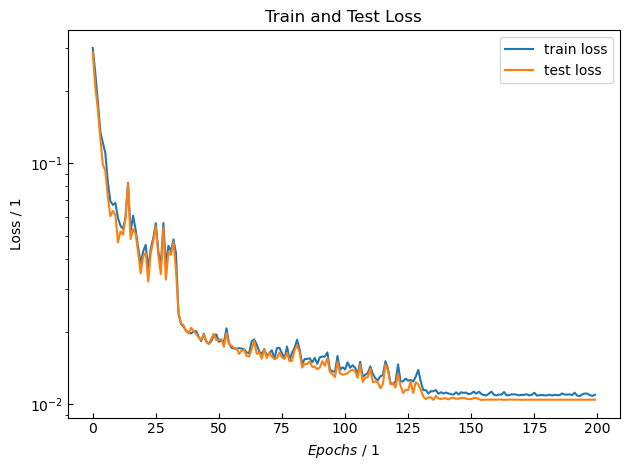

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Speichern Trainingskurve

In [11]:
np.savez('data/models/hyperparams/loss_005_005.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9996261083888656 , R^2(NH3) = 0.9986835760542717
Test Dataset: R^2(H2) = 0.9996617376682556 , R^2(NH3) = 0.999673779153895
Max Error Training: |x_H2 - x_H2,pred| = 0.06424736941695958 , |x_NH3 - x_NH3,pred| = 0.04159608162034928
Max Error Test: |x_H2 - x_H2,pred| = 0.019778235858555815 , |x_NH3 - x_NH3,pred| = 0.009054894894879817


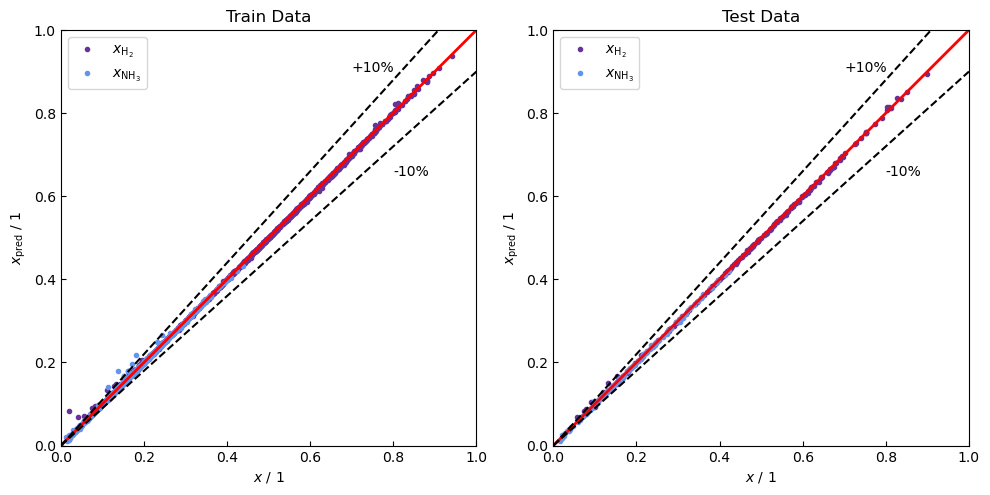

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

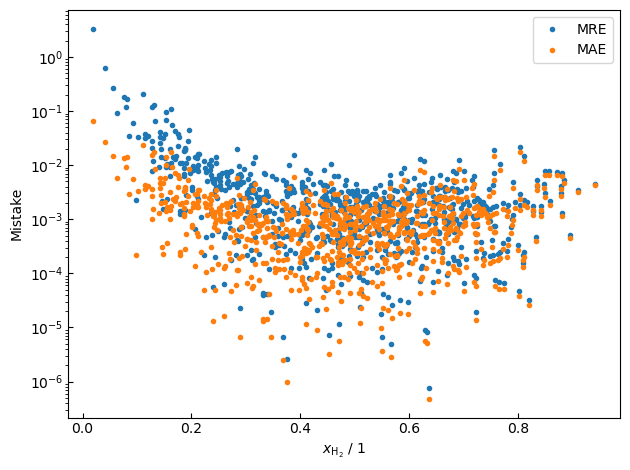

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

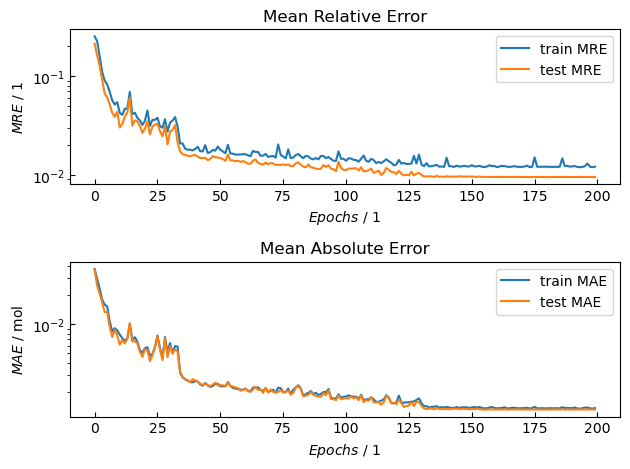

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

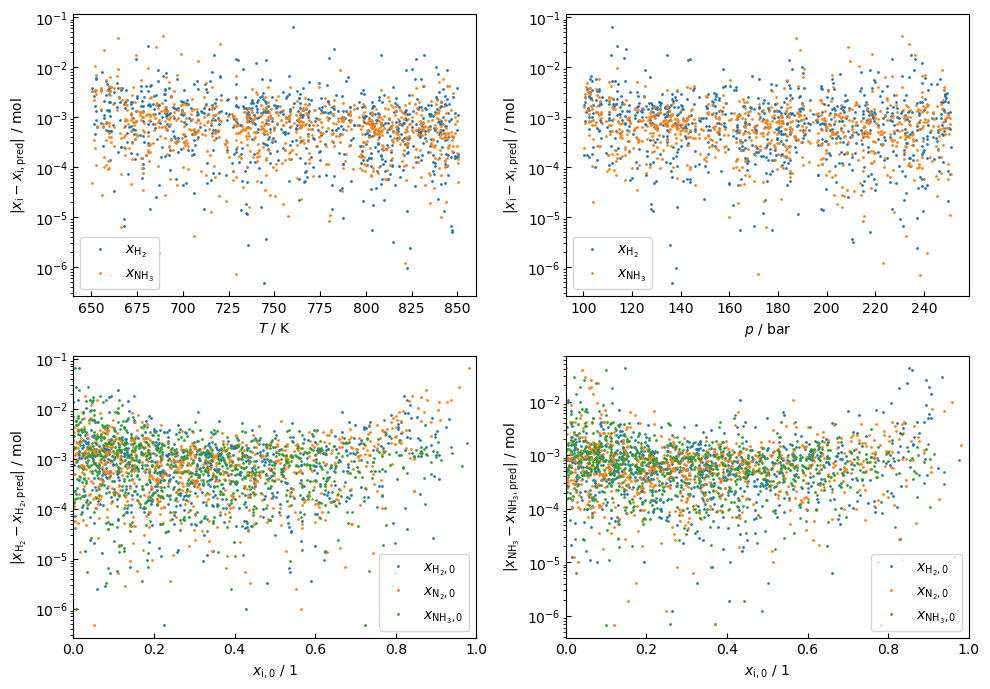

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

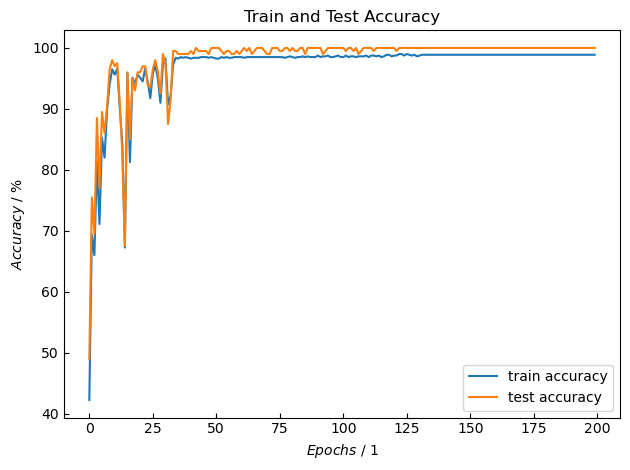

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.4107, -0.2790, -0.4997, -0.2015,  0.6964],
        [ 0.0647,  0.5565, -1.2876,  0.9926,  0.2492],
        [ 1.3241, -1.1693,  1.8177, -1.2254, -0.5314],
        [ 0.8064,  1.1247, -0.2626, -0.7805,  1.0554],
        [ 0.7585,  0.4759,  1.0682, -0.7902, -0.2407],
        [-0.9565, -0.5200, -0.5875,  1.4133, -0.8679],
        [-1.6864, -1.0646,  0.1264, -0.6090,  0.4984],
        [ 0.3820, -1.4799, -0.8625,  1.6130, -0.8021],
        [-0.4505, -1.5755,  0.2509, -1.0406,  0.8173],
        [ 1.1448,  0.0237,  1.2820, -0.8460, -0.3934],
        [ 1.4611, -0.6289,  0.6150,  0.2164, -0.8247],
        [-0.7026, -1.0340, -0.2733, -0.8294,  1.1159],
        [ 0.8819, -0.8620, -1.1970,  1.4515, -0.3089],
        [ 0.3433,  1.6548,  0.3925, -0.2837, -0.0952],
        [-1.2812, -1.4891,  1.7154, -1.1615, -0.4963],
        [ 1.2959,  0.3613,  1.6449, -1.1078, -0.4820],
        [ 0.4045,  1.6978, -0.8808,  1.9873, -1.1668],
        [ 1.5276,  0.1648, -0.0329, -0.7492,  0.7981],
        [-

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.1944,  0.2555,  0.1430,  0.0818, -0.1761],
         [-0.3174,  0.0897, -0.0861, -0.3176, -0.1307],
         [ 0.0055,  0.0117, -0.0354,  0.3300, -0.1898],
         [ 0.3274, -0.0827,  0.4798,  0.2312,  0.3921],
         [ 0.1866,  0.0328,  0.1248, -0.2743,  0.0895],
         [-0.3142,  0.3281,  0.0844,  0.3975,  0.0286],
         [ 0.0055,  0.0367,  0.3087, -0.1815,  0.1334],
         [ 0.3856,  0.0636, -0.0691, -0.4760, -0.0835],
         [ 0.3498, -0.1503, -0.0233,  0.0402, -0.1774],
         [-0.1229,  0.1973,  0.1466,  0.1255, -0.4246],
         [-0.1256,  0.0958,  0.4668,  0.1711,  0.3772],
         [-0.0372, -0.0532, -0.3169,  0.0853, -0.0979],
         [ 0.0017, -0.1408, -0.0111, -0.6369,  0.2031],
         [ 0.0633,  0.4897, -0.1032, -0.2894, -0.1106],
         [ 0.2248,  0.1357, -0.0447,  0.4942,  0.1228],
         [ 0.0372,  0.1779,  0.0629, -0.2968,  0.0564],
         [-0.3338,  0.0463, -0.0784, -0.3023,  0.0655],
         [ 0.1067,  0.153

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0649, 0.3946, 0.2440, 0.9525, 0.9967],
        [0.7673, 0.1209, 0.4917, 0.9426, 0.7146]])
tensor([[-0.1184,  0.6079],
        [ 0.0771,  0.1501]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 9.0272e-01,  5.9305e-01, -4.0910e-01,  8.7522e-01, -4.9306e-01],
        [ 3.5674e-01, -1.2205e+00,  2.9521e-01, -1.3373e+00,  1.0771e+00],
        [-1.1599e+00,  1.4961e+00,  3.0567e-01, -7.5051e-01,  4.6710e-01],
        [ 1.5276e+00,  1.6484e-01, -3.2924e-02, -7.4924e-01,  7.9809e-01],
        [-8.5466e-01,  8.6789e-02, -1.3352e+00,  2.5750e-01,  1.0471e+00],
        [-3.4351e-01, -7.2208e-01, -1.0479e+00,  1.4754e+00, -4.7957e-01],
        [ 8.8193e-01, -8.6195e-01, -1.1970e+00,  1.4515e+00, -3.0886e-01],
        [ 2.2979e-01,  1.0088e+00,  2.0413e+00, -6.2863e-01, -1.3608e+00],
        [ 9.5982e-03, -2.4183e-01,  7.4297e-01,  1.3177e-01, -8.6382e-01],
        [ 1.2700e+00,  1.6214e+00, -6.5642e-01,  1.9812e+00, -1.3807e+00],
        [-7.0873e-01,  6.3433e-01, -1.2216e+00,  5.5331e-01,  6.3335e-01],
        [ 4.7153e-02, -9.8757e-01, -1.3713e+00,  1.8218e+00, -5.1619e-01],
        [ 4.0981e-01,  1.6669e+00, -1.3793e+00,  1.9584e+00, -6.4803e-01],
        [ 1.1662e-01, -8.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()